- 스트리밍 복제에서는 세 가지 유형의 프로세스가 협력적으로 작동.

- 기본 서버의 walsender 프로세스는 WAL(Write-Ahead Log) 데이터를 대기 서버로 보냄 .
- 대기 서버의 walreceiver 프로세스는 WAL 데이터를 수신하고 재생  .
- 대기 서버의 시작 프로세스 는 walreceiver 프로세스를 시작.

<br>
- walsender와 walreceiver는 단일 TCP 연결을 사용하여 통신.



**SR startup sequence.**

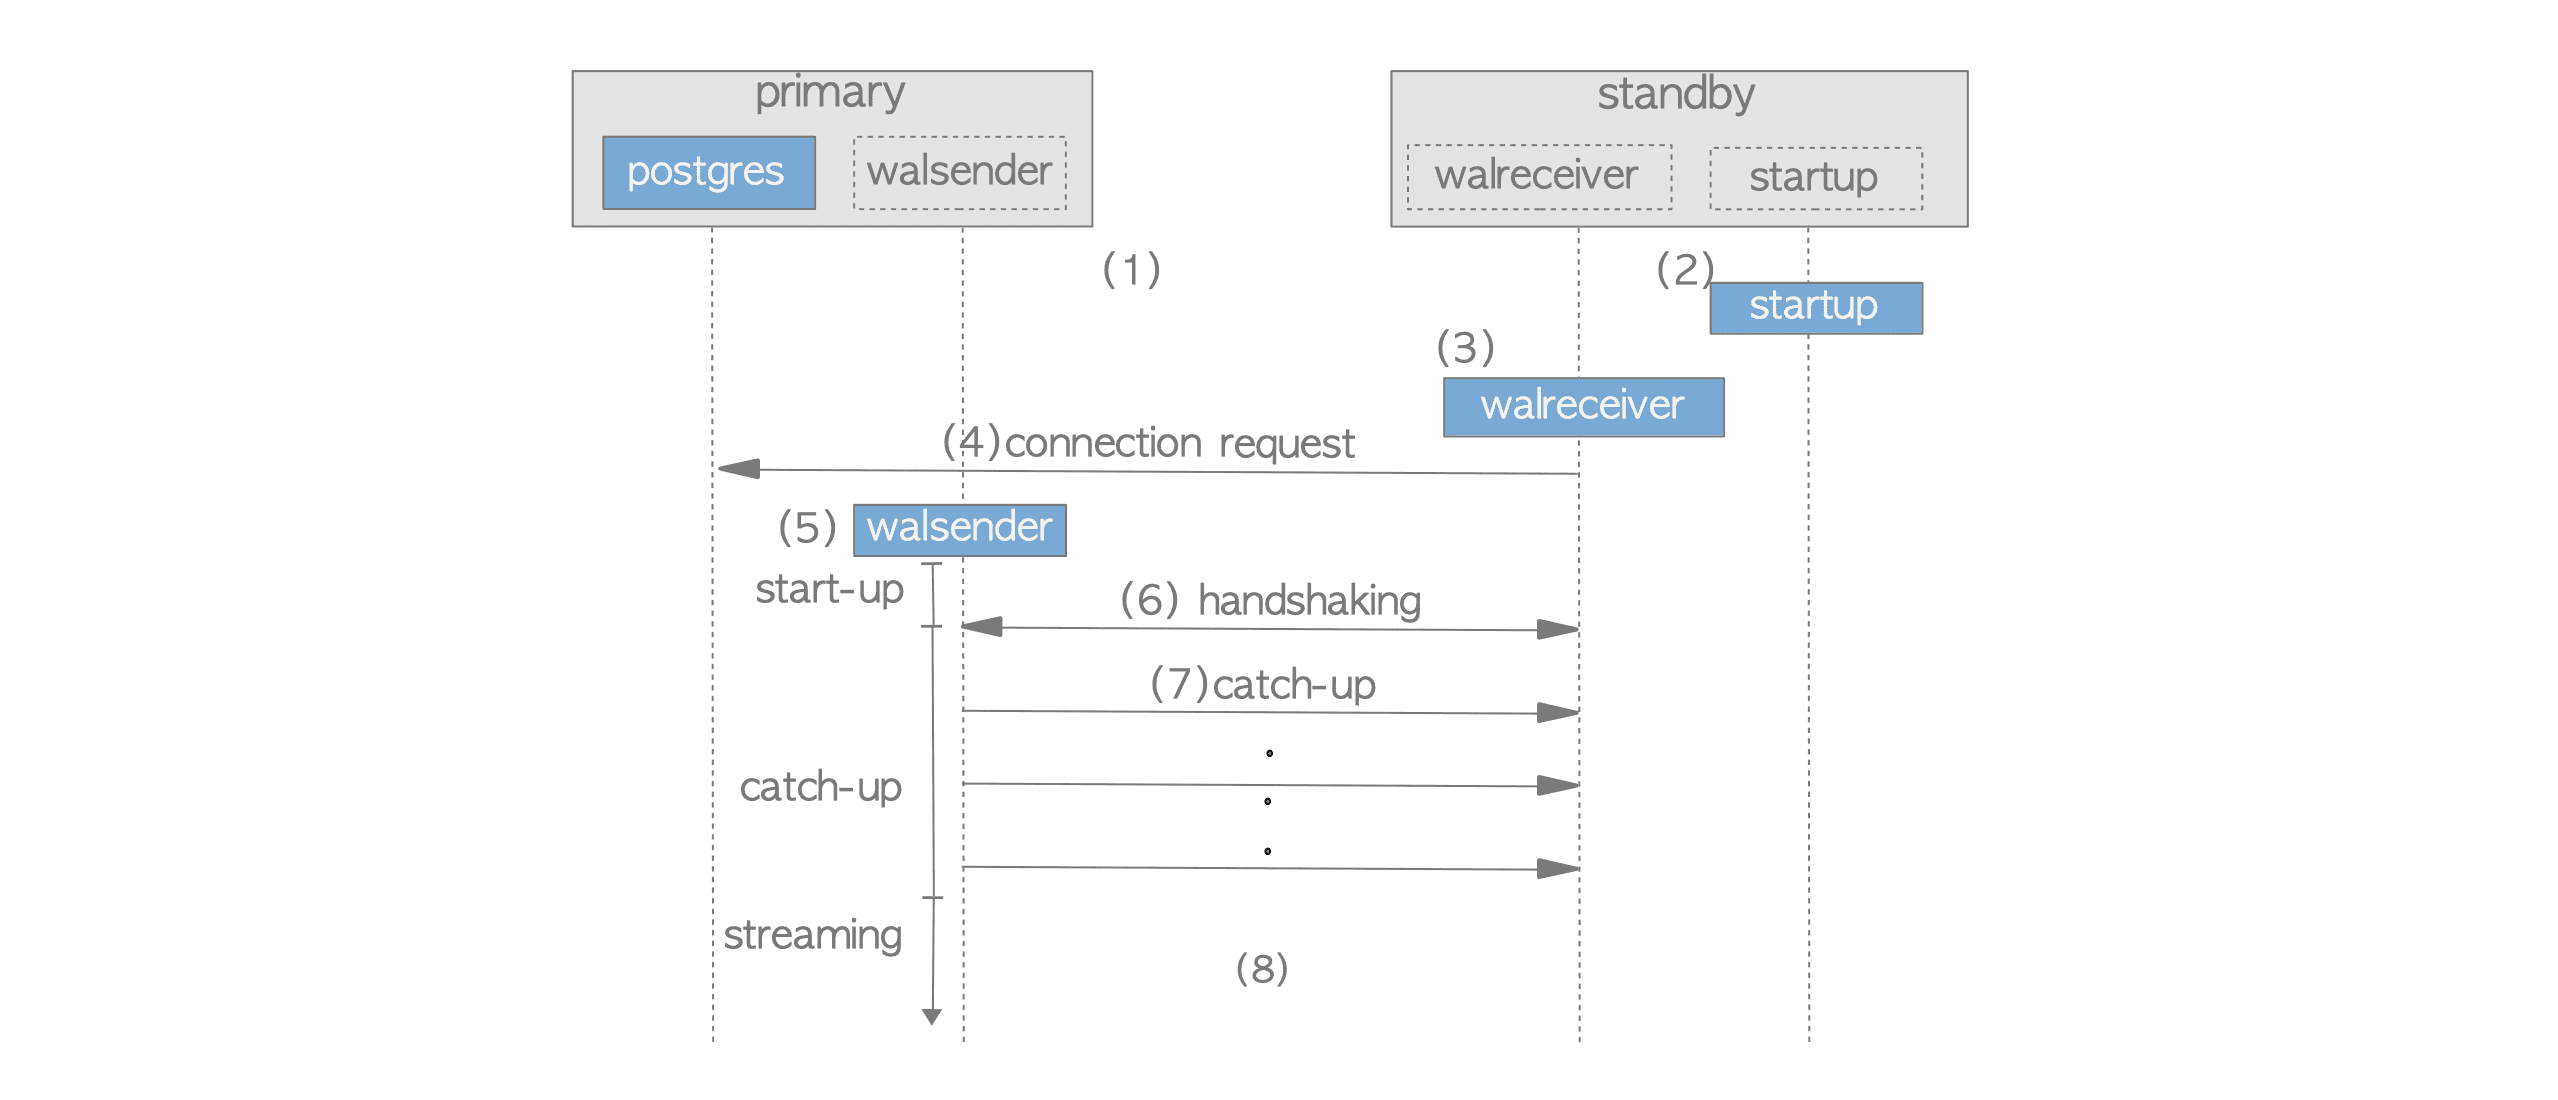

1. 기본 및 대기 서버를 시작.

2. 대기 서버가 시작 프로세스를 시작.

3. 대기 서버는 Walreceiver 프로세스를 시작.

4. 월리시버는 기본 서버에 연결 요청을 보냄.
  - 기본 서버가 실행되고 있지 않으면 Walreceiver는 이러한 요청을 주기적으로 보냄.

5. 기본 서버는 연결 요청을 받으면 walsender 프로세스를 시작하고 walsender와 walreceiver 사이에 TCP 연결이 설정됩니다.

6. Walreceiver는 대기 데이터베이스 클러스터의 최신 LSN(Log Sequence Number)을 전송.
  - 이를 정보 기술 분야에서는 핸드셰이킹 이라고 함.

7. 대기의 최신 LSN이 기본의 최신 LSN(대기의 LSN)보다 작은 경우
< Primary의 LSN), Walsender는 이전 LSN의 WAL 데이터를 후자 LSN으로 보냄. 이러한 WAL 데이터는 기본의 pg_wal 하위 디렉터리(버전 9.6 이하에서는 pg_xlog)에 저장된 WAL 세그먼트에 의해 제공됨.
  - 그런 다음 대기 서버는 수신된 WAL 데이터를 재생.
  - 이 단계에서는 대기가 기본을 따라잡으므로 이를 따라잡기 라고 함.

8. 스트리밍 복제가 작동하기 시작.

<br>

- 각 Walsender 프로세스는 연결된 WalReceiver 또는 애플리케이션의 작업 단계에 적합한 상태를 유지.

**Walsender 프로세스의 가능한 상태**

start-up - Walsender 시작부터 핸드쉐이킹 종료까지
catch-up - 따라잡기 단계 중
streaming  - 스트리밍 복제가 작동하는 동안
backup  - pg_basebackup 유틸리티 와 같은 백업 도구를 위해 전체 데이터베이스 클러스터의 파일을 보내는 중.

<br>

pg_stat_replication 뷰 는 실행 중인 모든 walsender의 상태를 보여줌


```
testdb=# SELECT application_name,state FROM pg_stat_replication;
 application_name |   state
------------------+-----------
 standby1         | streaming
 standby2         | streaming
 pg_basebackup    | backup
(3 rows)
```

- 위 결과에서 볼 수 있듯이 연결된 대기 서버에 대한 WAL 데이터를 전송하기 위해 두 개의 walsender가 실행되고 있고, 다른 하나는 pg_basebackup 유틸리티 에 대한 데이터베이스 클러스터의 모든 파일을 전송하기 위해 실행되고 있음

**What will happen if a standby server restarts after a long time in the stopped condition?**

- 버전 9.3 이하에서는 대기 서버에 필요한 기본 서버의 WAL 세그먼트가 이미 재활용된 경우 대기 서버가 기본 서버를 따라잡을 수 없음.

- 이 문제에 대한 신뢰할 수 있는 해결책은 없지만 발생 가능성을 줄이기 위해 구성 매개변수 wal_keep_segments 에 큰 값을 설정하는 것뿐.
  - 이것은 임시방편의 솔루션.

- 9.4 버전 이상에서는 복제 슬롯을 사용하면 이 문제를 방지할 수 있음
  - 복제 슬롯은 주로 논리적 복제를 위해 WAL 데이터 전송의 유연성을 확장하는 기능으로, 이 문제에 대한 솔루션도 제공.
  - 즉, pg_wal (또는 버전 9.6 이하의 경우 pg_xlog )아래에 전송되지 않은 데이터가 포함된 WAL 세그먼트 파일 )은 재활용 프로세스를 일시 중지하여 복제 슬롯에 보관할 수 있음